# NMF and SVD

The idea of this project is to build a simple movie recomendation system based on the NMF and SVD factorization method.

Let us consider a rather small dataset of movies ratings (only 5 users and 5 movies).
At some point in time the rankings look like this.

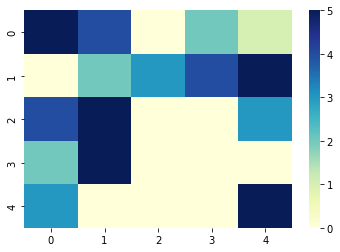

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import tqdm

from scipy.linalg import sqrtm

M = np.array([[5,4,0,2,1], [0,2,3,4,5], [4,5,0,0,3],[2,5,0,0,0], [3,0,0,0,5]])
ax = sn.heatmap(M, cmap="YlGnBu")

In [34]:
def rmse(A,B):
    mask = A!=0.0
    return np.sqrt((np.power(B - A, 2)).mean())

In [3]:

def nmf_mu(X, k, n=1000, l=1E-3, seed=None):
    if isinstance(seed,int):
        np.random.seed(seed)
    
    rows, columns = X.shape
    eps = np.finfo(float).eps

    # Create W and H
    #avg = np.sqrt(X.mean() / k)
    
    W = np.abs(np.random.uniform(size=(rows, k)))
    #W = avg * np.maximum(W, eps)
    W = np.maximum(W, eps)
    W = np.divide(W, k*W.max())

    H = np.abs(np.random.uniform(size=(k, columns)))
    #H = avg * np.maximum(H, eps)
    H = np.maximum(H, eps)
    H = np.divide(H, k*H.max())

    # Create a Mask
    M = X > 0.0

    for _ in tqdm.tqdm(range(n)):
        W = np.multiply(W, np.divide((M*X)@H.T-l*np.linalg.norm(W, 'fro'), (M*(W@H))@H.T))
        W = np.maximum(W, eps)
        H = np.multiply(H, np.divide(W.T@(M*X)-l*np.linalg.norm(H, 'fro'), W.T@(M*(W@H))))
        H = np.maximum(H, eps)

        Xr = W @ H
        cost = np.linalg.norm((M*X) - (M*Xr), 'fro')
        if cost <= l:
            break
    
    return Xr, W, H, cost

### 1. Compute the recommendations using NMF

100%|██████████| 1000/1000 [00:00<00:00, 14023.74it/s]


RMSE = 1.347467706774432


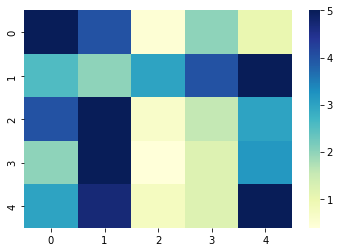

In [38]:
Xr, W, H, cost = nmf_mu(M, 5)
ax = sn.heatmap(Xr, cmap="YlGnBu")
error = rmse(M, Xr)
print(f'RMSE = {error}')

### 2. Compute the recommendations using SVD

In [30]:
def svd(X, k):
    
    mask = X == 0.0
    masked_arr = np.ma.masked_array(X, mask)
    item_means = np.mean(masked_arr, axis=0)
    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    
    x = np.tile(item_means, (X.shape[0],1))    
    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    utilMat = utilMat - x
    # The magic happens here. U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)
    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x 
    return UsV

RMSE = 1.969771560359221


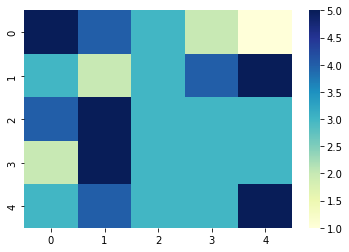

In [37]:
Xr = svd(M, 5)
ax = sn.heatmap(Xr, cmap="YlGnBu")
error = rmse(M, Xr)
print(f'RMSE = {error}')